In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import YouTubeVideo, display, Image

%matplotlib inline

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/089r2yg6aao858l/opencv_bootcamp_assets_NB14.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB14.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)  

Highlights
Train elsewhere, perform inference in an OpenCV application

Supports Caffe, Tensorflow, Torch and Darknet.

Supported layers : AbsVal, AveragePooling, BatchNormalization, Concatenation, Convolution (including dilated convolution), Crop, Deconvolution, DetectionOutput (SSD-specific layer), Dropout, Eltwise (+, *, max), Flatten, FullyConnected, LRN, LSTM, MaxPooling, MaxUnpooling, MVN, NormalizeBBox (SSD-specific layer), Padding, Permute, Power, PReLU (including ChannelPReLU with channel-specific slopes), PriorBox (SSD-specific layer), ReLU, RNN, Scale, Shift, Sigmoid, Slice, Softmax, Split, TanH

Use Caffe model trained on the Multi-Person Image Dataset (MPI) to demonstrate human pose estimation for a single person.

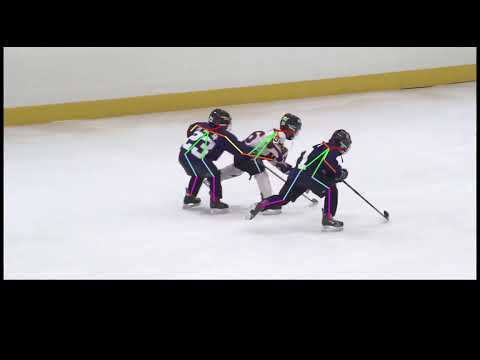

In [4]:
video = YouTubeVideo("RyCsSc_2ZEI", width=1024, height=640)
display(video)

Load a Caffe Model
A typical Caffe Model has two files

Architecture : Defined in a .prototxt file
Weights : Defined in .caffemodel file

In [5]:
protoFile = "pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = os.path.join("model","pose_iter_160000.caffemodel")

In [6]:
#This changes with what we want to detect, this is for human pose estimation, for hand pose estimation, we need to change the prototxt and caffemodel files
nPoints = 15
POSE_PAIRS = [[0,1],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[1,14],[14,8],[8,9],[9,10],[14,11],[11,12],[12,13]]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)


In [26]:
img = cv2.imread("Tiger_Woods.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
inWidth = img.shape[1]
inHeight = img.shape[0]

print(f"Image width={inWidth}, height={inHeight}")

Image width=1658, height=1058


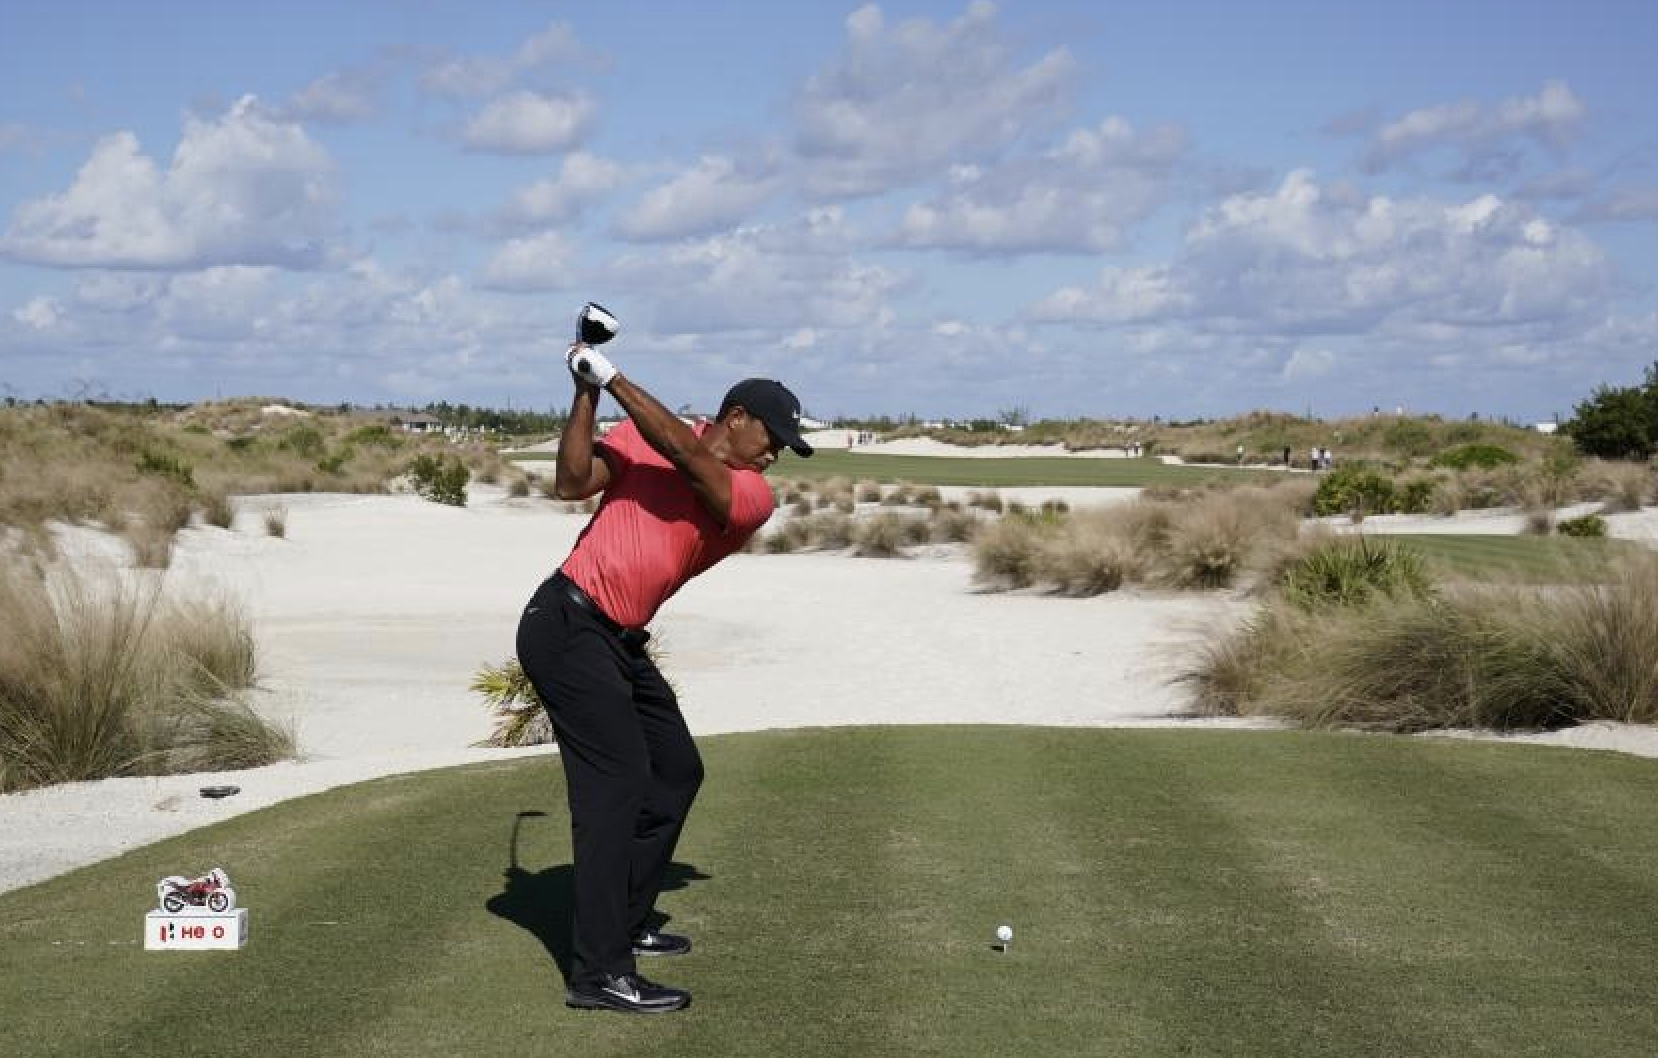

In [27]:
Image(filename='Tiger_Woods.png')

In [28]:
netInputSize = (368,368)
#How do you know it is 368,368? It is in the prototxt file, look for input dimension
inpBlob = cv2.dnn.blobFromImage(img, 1.0 / 255, netInputSize, (0, 0, 0), swapRB=True, crop=False)
net.setInput(inpBlob)

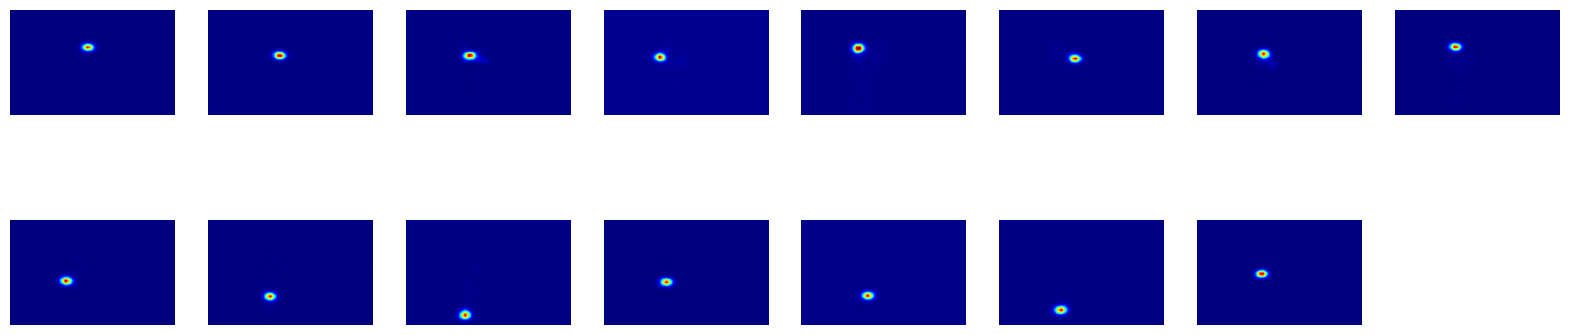

In [29]:
#Forward pass
output = net.forward()

#Display the probability maps
plt.figure(figsize=(20,5))
for i in range(nPoints):
    probMap = output[0,i,:,:]
    displayProbMap = cv2.resize(probMap, (inWidth, inHeight),cv2.INTER_LINEAR)
    
    plt.subplot(2,8,i+1)
    plt.axis("off")
    plt.imshow(displayProbMap,cmap="jet")
    




If you are enlarging the image, you should prefer to use INTER_LINEAR or INTER_CUBIC interpolation. If you are shrinking the image, you should prefer to use INTER_AREA interpolation.

Cubic interpolation is computationally more complex, and hence slower than linear interpolation. However, the quality of the resulting image will be higher.

In [35]:
#Scale the image
scaleX = inWidth/output.shape[3]
scaleY = inHeight/output.shape[2]

print(scaleX,scaleY)

print(output.shape[3],output.shape[2])

#Empty list to store the detected keypoints
points = []

#Threshold
threshold = 0.1

for i in range(nPoints):
    #Obtain the probability map
    probMap = output[0,i,:,:]
    #Find global maxima of the probability map
    minVal,prob,minLoc,point = cv2.minMaxLoc(probMap)
    
    
    #Scale the point to fit on the original image
    x = scaleX*point[0]
    y = scaleY*point[1]
    
    if prob > threshold:
        points.append((int(x),int(y)))
    else:
        points.append(None)
        
print(points)

46 46
[(756, 368), (720, 460), (612, 460), (540, 460), (576, 391), (756, 483), (648, 437), (576, 368), (540, 598), (612, 759), (576, 943), (612, 621), (648, 759), (612, 897), (648, 529)]


In [36]:
imPoints = img.copy()
imSkeleton = img.copy()

print(points)

#Draw the detected points
for i,p in enumerate(points):
    cv2.circle(imPoints,p,8,(255,255,0),thickness=-1,lineType=cv2.FILLED)
    cv2.putText(imPoints,"{}".format(i),p,cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2,cv2.LINE_AA)
    
#Draw Skeleton
for pair in POSE_PAIRS:
    partA  = pair[0]
    partB = pair[1]
    
    if points[partA] and points[partB]:
        cv2.line(imSkeleton,points[partA],points[partB],(255,255,0),2)
        cv2.circle(imSkeleton,points[partA],8,(255,0,0),thickness=-1,lineType=cv2.FILLED)

[(756, 368), (720, 460), (612, 460), (540, 460), (576, 391), (756, 483), (648, 437), (576, 368), (540, 598), (612, 759), (576, 943), (612, 621), (648, 759), (612, 897), (648, 529)]


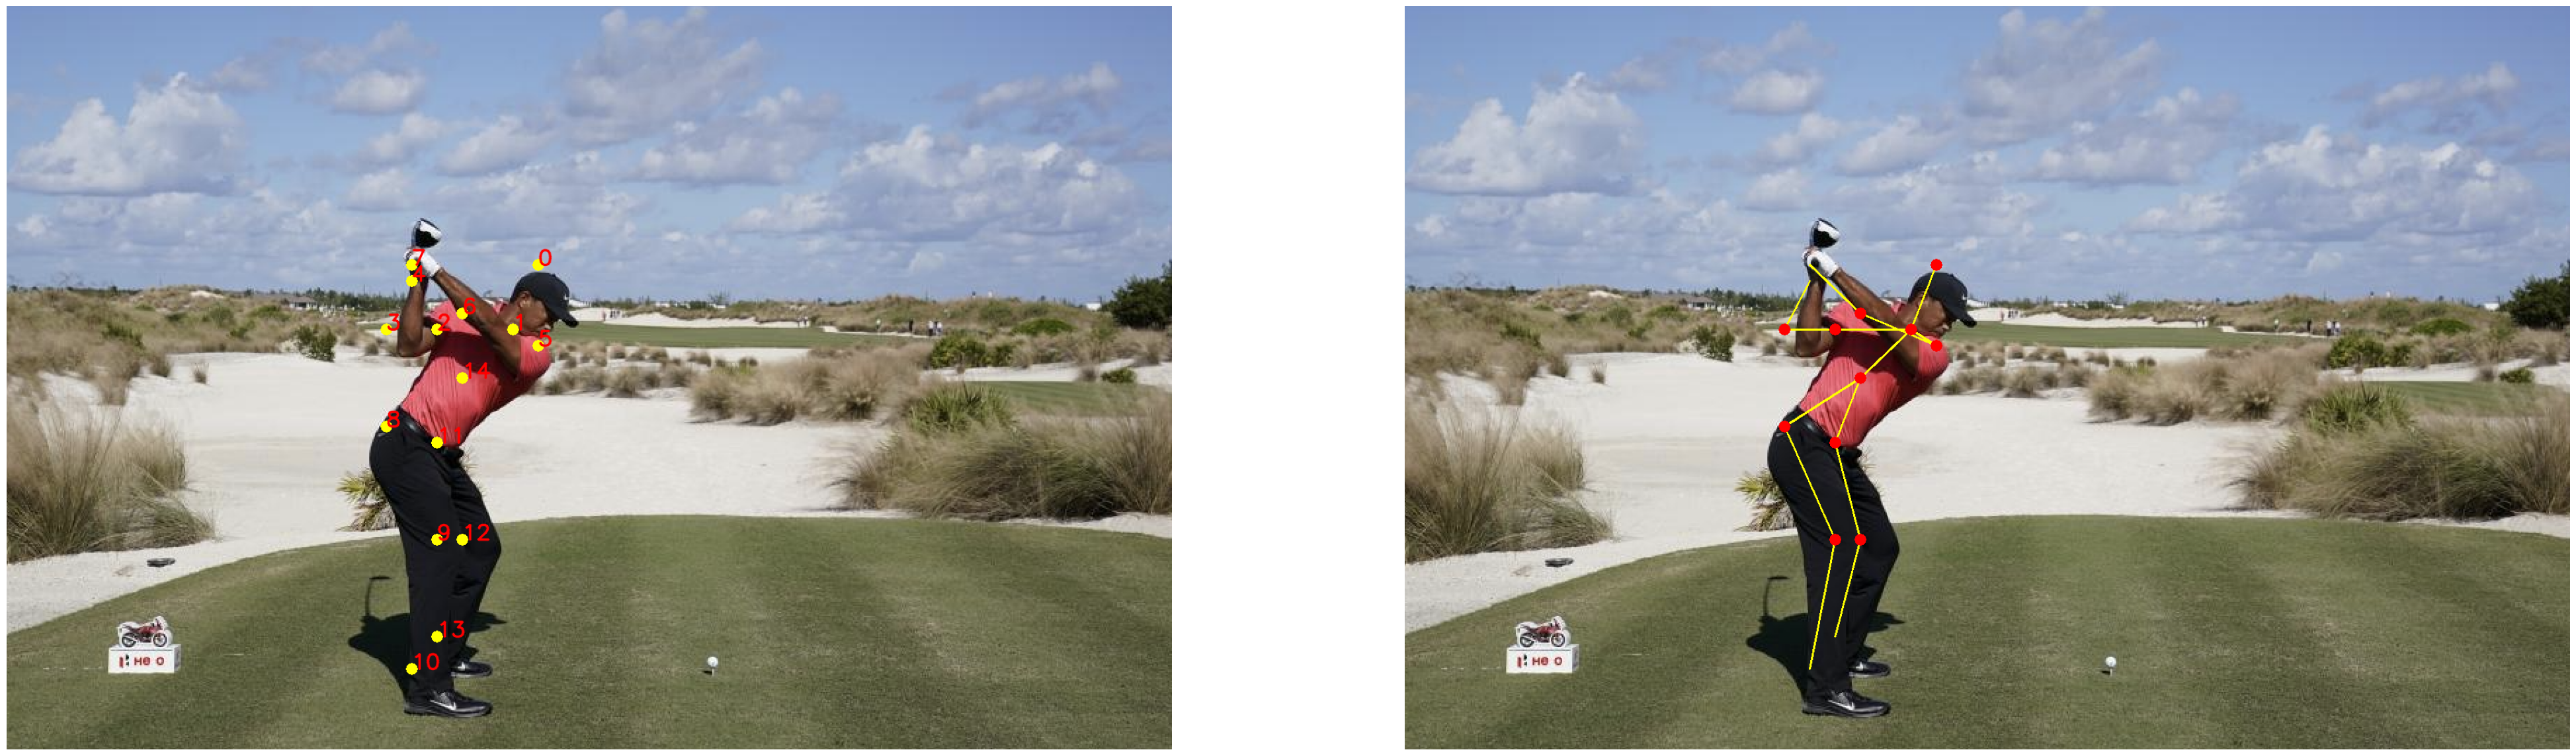

In [34]:
plt.figure(figsize=(50,50))
plt.subplot(1,2,1);plt.axis("off");plt.imshow(imPoints)
plt.subplot(1,2,2);plt.axis("off");plt.imshow(imSkeleton)